# Algorytm genetyczny - cutting stock problem

## Aleksandra Wichrowska, 291140

"Potwierzam samodzielność poniższej pracy i niekorzystanie przeze mnie z niedozwolonych źródeł." 

~ Aleksandra Wichrowska

# Założenia

## Inicjalizacja populacji

Początkowa populacja zostaje zainicjalizowana w dwóch krokach:

**1. Wygenerowanie jednego osobnika dla każdego z typów prostokątów**

Prostokąty danego typu są rozmieszczane na średnicy okręgu, zaczynamy od środka okręgu i dostawiamy równomiernie w lewo i w prawo. Później powtarzamy operacją na cięciwie wyznaczonej przez górę wstawionych prostokątów. Opisany algorytm zapełnia 'górną część koła', dolną zapełniamy symetrycznie.

Przykład wygenerowanych w ten sposób osobników:

W ten sposób zostaje wygenerowanych $2k$ osobników, gdzie $k$ to liczba typów dostępnych prostokątów (każdy prostokąt rozpatrujemy osobno w położeniu poziomym i pionowym). 

**2. Wygenerowanie kolejnych osobników**

Kolejne osobniki do początkowej populacji generujemy w wyniku krzyżowania już istniejących oraz dopełniania dodatkowymi prostokątami.

## Krzyżowanie

* wylosowanie osobników do krzyżowania odbywa się za pomocą selekcji ruletkowej - osobniki są wybierane z prawdopodobieństwem proporcjolanym do osiąganego wyniku funkcji celu. W ten sposób lepiej przystosowane osobniki będą wybierane z większym prawdopodobieństwem.

* losowanie wartości z przedziału $(0,radius)$

* losowanie kierunku (pionowy/poziomy)

Krzyżowanie odbywa się na zasadzie podobnej do krzyżowania gaussowskiego z jednym punktem podziału. Wybieramy linię (poziomą lub pionową), która dzieli koło zawierające prostokąty na dwie częsci. Wyrzucamy prostokąty, które zostały przecięte przez linię podziału. Krzyżujemy dwa wybrane osoniki (A i B) przez sklejene górnej częsci osobnika A z dolną częscia osonika B (i na odwrót). W wyniku krzyżowania powstają dwa nowe osobniki.

Ponieważ usuwanie prostokątów przeciętych przez linię podziału może powodować powstawanie sporych 'dziur' po krzyżowaniu każdy z nowych osobników poddajemy funkcji `add_rectangles`. Iteruje się  ona po wierzchołkach istniejących w kole prostokątów i próbuje wstawiać w tych miejsach nowe prostokąty różnych typów.
(Wstawienie nowych prostokątów zawsze 'opłaca się', tzn. zwiększa wartość funkcji celu).

## Mutacja

Rozpatruję różne rodzaje mutacji:

1. obrót osobnika o 90 stopni.
2. usunięcie losowego prostokąta 

3. przesuwanie prostokąta (miało być, ale nie zdążyłam :/)

## Selekcja

Selekcja osobników do nowej generacji odbywa się w dwóch etapach:

1. Elitaryzm - 20% najlepszych osobników automatycznie przechodzi do kolejnej generacji (zapewnia do utrzymanie najlepszego rozwiązania)

2. Selekcja ruletkowa - pozostałe 80% populacji jest wybierane za pomocą selekcji ruletkowej.

## Import potrzebnych bibliotek

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy, copy
import pandas as pd
import random

In [2]:
%%capture
from tqdm.notebook import tqdm

## Funkcje pomocnicze

In [3]:
def read_data(radius):
    rectangles_table1 = pd.read_csv('cutting/r'+str(radius)+'.csv', header=None)
    rectangles_table1.columns = ['width', 'height', 'value']
    rectangles_table2 = pd.read_csv('cutting/r'+str(radius)+'.csv', header=None)
    rectangles_table2.columns = ['height', 'width', 'value']
    rectangles_table = pd.concat([rectangles_table1, rectangles_table2])
    rectangles_table.index = range(rectangles_table.shape[0])
    rectangles_table = rectangles_table.iloc[np.argsort(rectangles_table.width*rectangles_table.height/rectangles_table.value),]
    return rectangles_table

def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

## Klasa algorytmu genetycznego

In [4]:
class GeneticAlgorithm:
    
    def __init__ (self, radius, n=100, elit = 0.2, rotation_ratio = 0.1, deletion_ratio = 0.1):
        self.n = n
        self.radius = radius
        self.rectangles_table = read_data(self.radius)
        self.generate_start_population()
    
        # parameters
        self.elit = elit
        self.rotation_ratio = rotation_ratio
        self.deletion_ratio = deletion_ratio
    
    ##################################
    ######### INIT POPULATION ########
    ##################################
        
    def generate_start_population(self):
        population = self.generate_basic()
        population = self.generate_more(population)
        self.population = population
    
    def generate_basic(self):
        population = []
        for i in range(self.rectangles_table.shape[0]):
            population.append(self.initialize_rectangles(i)) 
        return population
    
    def initialize_rectangles(self, rect_type):
        rectangles_list = []

        width = self.rectangles_table.iloc[rect_type].width
        height = self.rectangles_table.iloc[rect_type].height

        x_n = int(self.radius/width)
        y_n = int(self.radius/height)

        for y in range(1,y_n+1):
            for x in range(1,x_n+1): 
                rect1 = Rect(-int(x*width), (y-1)*height, rect_type)
                rect2 = Rect(int((x-1)*width), (y-1)*height, rect_type)
                rect3 = Rect(int((x-1)*width), -y*height, rect_type)
                rect4 = Rect(-int(x*width), -y*height, rect_type)

                if rect1.check_include(self.radius):
                    rectangles_list.append(rect1)
                    rectangles_list.append(rect2)
                    rectangles_list.append(rect3)
                    rectangles_list.append(rect4)
                else:
                    break
        
        return rectangles_list    
    
    def generate_more(self, population):
        new_population = []

        for r in population:
            new_population.append(r)

        while len(new_population) < self.n:
            r1,r2 = np.random.choice(new_population, 2)
            r1_new, r2_new = self.generate_new_individual(r1, r2)
            new_population.append(r1_new)
            new_population.append(r2_new)
            
        return new_population
    
    
    ##################################
    ############ EVALUATION ##########
    ##################################
    
    def evaluate(self):
        evaluation = []
        for individual in self.population:
            evaluation.append(self.evaluate_individual(individual))
        return evaluation
    
    def evaluate_individual(self,individual):    
        value = 0
        for rect in individual:
            value += rect.value
        return value
    
    
    ##################################
    ############ MUTATION ############
    ##################################
    
    def add_rectangles(self,individual):
        anchors = ['left-down', 'right-down', 'left-up', 'right-up']
        
        for i in range(self.rectangles_table.shape[0]):
            actions = []
            for rect in individual:

                corners = [(rect.x0,rect.y0),(rect.get_x1(),rect.y0),(rect.x0,rect.get_y1()),(rect.get_x1(),rect.get_y1())]

                for index, corner in enumerate(corners):

                    for index_anchor, anchor in enumerate(anchors):

                        if index_anchor != index:
                            
                            actions.append([corner[0], corner[1], anchor])
        
            actions = unique_rows(actions)
            random.shuffle(actions)
            for [x,y,anchor] in actions:                    
                new_rect = Rect(rect_type = int(i))
                new_rect.set_coordinates(int(x), int(y), anchor)
                if new_rect.check_rectangle(self.radius, individual):
                    individual.append(new_rect)

        return individual
    
    def rotate_individual(self, individual):
        for index, rect in enumerate(individual):
            new_rect = copy(rect)
            new_rect.x0, new_rect.y0 = -new_rect.y0, -new_rect.x0 
            new_rect.width, new_rect.height = new_rect.height, new_rect.width
            new_rect.x0 -= new_rect.width
            new_rect.y0 -= new_rect.height
            individual[index] = new_rect
    
    def rotate_population(self):
        choice = np.random.choice(len(self.population), int(self.rotation_ratio*self.n))
        for i in range(len(choice)):
            self.rotate_individual(self.population[choice[i]])
            
    def delete_rectangle(self, individual):
        i = np.random.randint(len(individual),1)
        individual.pop(i)
        
    def delete_mutation(self):
        choice = np.random.choice(len(self.population), int(self.deletion_ratio*self.n))
        for i in range(len(choice)):
            individual = self.population[choice[i]]
            individual = self.add_rectangles(individual)
            
    def move_rectangle(self, individual):
        i = np.random.randint(len(individual),1)
        rectangle = individual[i]
        direction = np.random.choice(['left', 'right', 'up', 'down'], 1)
        step = radius/100
        for i in range(100):
            new_rect = Rect(rectangle.x0-step*i, rectangle.y0, rectangle.rect_type)
            if rectangle.check_rectangle(self.radius, individual):
                tmp = new_rect
                i+=1
            else:
                individual[i] = tmp

    ##################################
    ########### CROSS OVER ###########
    ##################################
    
    def cross_over_population(self):
        for i in range(int(self.n/4)):
            [r1, r2] = self.select_by_roulette(2)
            r1_new, r2_new = self.generate_new_individual(r1, r2)
            self.population.append(r1_new)
            self.population.append(r2_new)
            
    ##################################
    ########### SELECTTION ###########
    ##################################    
    
    def select_by_roulette(self,n):
        
        population_sorted = sorted(self.population,key=self.evaluate_individual, reverse=True)
        fitness_sum = sum(self.evaluate()) 
        
        selected_population = []
        
        if n > 2:
            elit = int(n*self.elit)
            selected_population[:elit] = population_sorted[:elit]
            n -= elit
        
        for i in range(n):
            draw = random.uniform(0, 1)

            accumulated = 0
            for individual in population_sorted:
                fitness = self.evaluate_individual(individual) 
                probability = fitness / fitness_sum
                accumulated += probability

                if draw <= accumulated:
                    selected_population.append(individual)
                    break
        return selected_population
    
    ##################################
    ######### NEW GENERATION #########
    ##################################
    
    def generate_new_individual(self,r1, r2):
        line = np.random.uniform(0,self.radius)
        vertical = np.random.choice([True, False], 1)

        r1_new = []
        r2_new = []
        if vertical:
            for rect in r1:
                if rect.y0 > line:
                    r1_new.append(rect)
                if rect.get_y1() < line:
                    r2_new.append(rect)
            for rect in r2:
                if rect.y0 > line:
                    r2_new.append(rect)
                if rect.get_y1() < line:
                    r1_new.append(rect)
        else:
            for rect in r1:
                if rect.x0 > line:
                    r1_new.append(rect)
                if rect.get_x1() < line:
                    r2_new.append(rect)
            for rect in r2:
                if rect.x0 > line:
                    r2_new.append(rect)
                if rect.get_x1() < line:
                    r1_new.append(rect)   
        r1_new = self.add_rectangles(r1_new)
        r2_new = self.add_rectangles(r2_new)
        return r1_new, r2_new

    ##################################
    ############ TRAINING ############
    ##################################
        
    def train_one_epoch(self):
        self.cross_over_population()
        self.rotate_population()
        self.delete_mutation()
        self.population = self.select_by_roulette(self.n)        
        
    def train_population(self, epochs=10):
        results = []
        results.append(max(self.evaluate()))
        best_individuals = []
        best_individuals.append(self.population[np.argsort(self.evaluate())[-1]])
        my_list = list(range(epochs))
        for x in tqdm(my_list):
            self.train_one_epoch()
            results.append(max(self.evaluate()))
            best_individuals.append(self.population[np.argsort(self.evaluate())[-1]])
        return results, best_individuals

## Klasa prostokąta

In [5]:
class Rect:
    
    def __init__ (self,x0=0,y0=0,rect_type=None):
           
        self.x0 = x0
        self.y0 = y0
        self.rect_type = rect_type
        self.width = rectangles_table.iloc[self.rect_type].width
        self.height = rectangles_table.iloc[self.rect_type].height
        self.value = rectangles_table.iloc[self.rect_type].value
    
    def set_coordinates(self,x,y,corner):
        if corner == 'left-down':
            self.x0 = x
            self.y0 = y
        
        if corner == 'right-down':
            self.y0 = y
            self.x0 = x - self.width
            
        elif corner == 'right-up':
            self.x0 = x - self.width
            self.y0 = y - self.height
            
        elif corner == 'left-up':
            self.x0 = x
            self.y0 = y - self.height
    
    def check_rectangle(self, radius, individual):
        if not self.check_include(radius):
            return False
        for rect in individual:
            if self.check_intersection(self, rect):
                return False
        return True
    
    def check_include(self, radius):
        if (self.x0)**2 + (self.y0)**2 > radius**2:
            return False
        if (self.x0)**2 + (self.get_y1())**2 > radius**2:
            return False
        if (self.get_x1())**2 + (self.y0)**2 > radius**2:
            return False
        if (self.get_x1())**2 + (self.get_y1())**2 > radius**2:
            return False
        return True 
    
    def check_intersection(self, rect1, rect2):
        if(rect1.x0 >= rect2.get_x1() or rect2.x0 >= rect1.get_x1()): 
            return False
        if(rect1.y0 >= rect2.get_y1() or rect2.y0 >= rect1.get_y1()): 
            return False
        return True

    def get_x1(self):
        return self.x0 + self.width
    
    def get_y1(self):
        return self.y0 + self.height

## Wykresy

In [6]:
def plot_circle(radius, rectangles_list = []):
    circle1 = plt.Circle((0, 0), radius, color='r', fill=False)
    fig, ax = plt.subplots()

    plt.xlim(-1.1*radius, 1.1*radius)
    plt.ylim(-1.1*radius, 1.1*radius)
    ax.set_aspect(1)
    ax.add_artist(circle1)

    plt.grid(linestyle='--')
    for rect in rectangles_list:
        rectangle = patches.Rectangle((rect.x0,rect.y0),rect.width,rect.height,linewidth=1,edgecolor='r',facecolor='gray')
        ax.add_patch(rectangle)

    plt.show()
    
def plot_circles(radius, n, m, names, rectangles_lists = []):
    
    fig, axs = plt.subplots(n,m, figsize=(20,20))
        
    for index, rect_list in enumerate(rectangles_lists):
        i = int(index/m)
        j = index % m
        circle1 = plt.Circle((0, 0), radius, color='r', fill=False)

        axs[i,j].set_xlim(-1.1*radius, 1.1*radius)
        axs[i,j].set_ylim(-1.1*radius, 1.1*radius)
        axs[i,j].set_aspect(1)
        axs[i,j].add_artist(circle1)
        axs[i,j].set_title('Najlepszy osobnik w '+str(names[index])+' populacji')

        for rect in rect_list:
            rectangle = patches.Rectangle((rect.x0,rect.y0),rect.width,rect.height,linewidth=1,edgecolor='r',facecolor='gray')
            axs[i,j].add_patch(rectangle)
    fig.tight_layout()
    plt.show()    
    
def plot_results(results):
    plt.figure()
    plt.plot(results)
    plt.ylabel('Wynik najlepszego osobnika w populacji')
    plt.xlabel('Numer generacji')
    plt.show()

# Testy

## `radius = 800`, pozostałe parametry domyślne, 30 osobników, 100 generacji

In [7]:
radius = 800
rectangles_table = read_data(radius)
ga = GeneticAlgorithm(radius, 30)

In [8]:
results, best_individuals = ga.train_population(100)

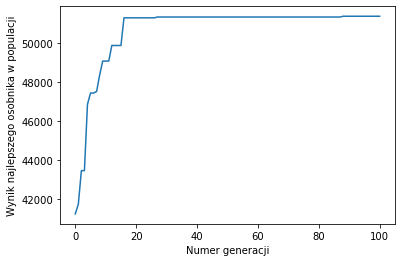

In [9]:
plot_results(results)

In [10]:
print('wartość startowa:', results[0])
print('wartość końcowa:', results[-1])

wartość startowa: 41220
wartość końcowa: 51360


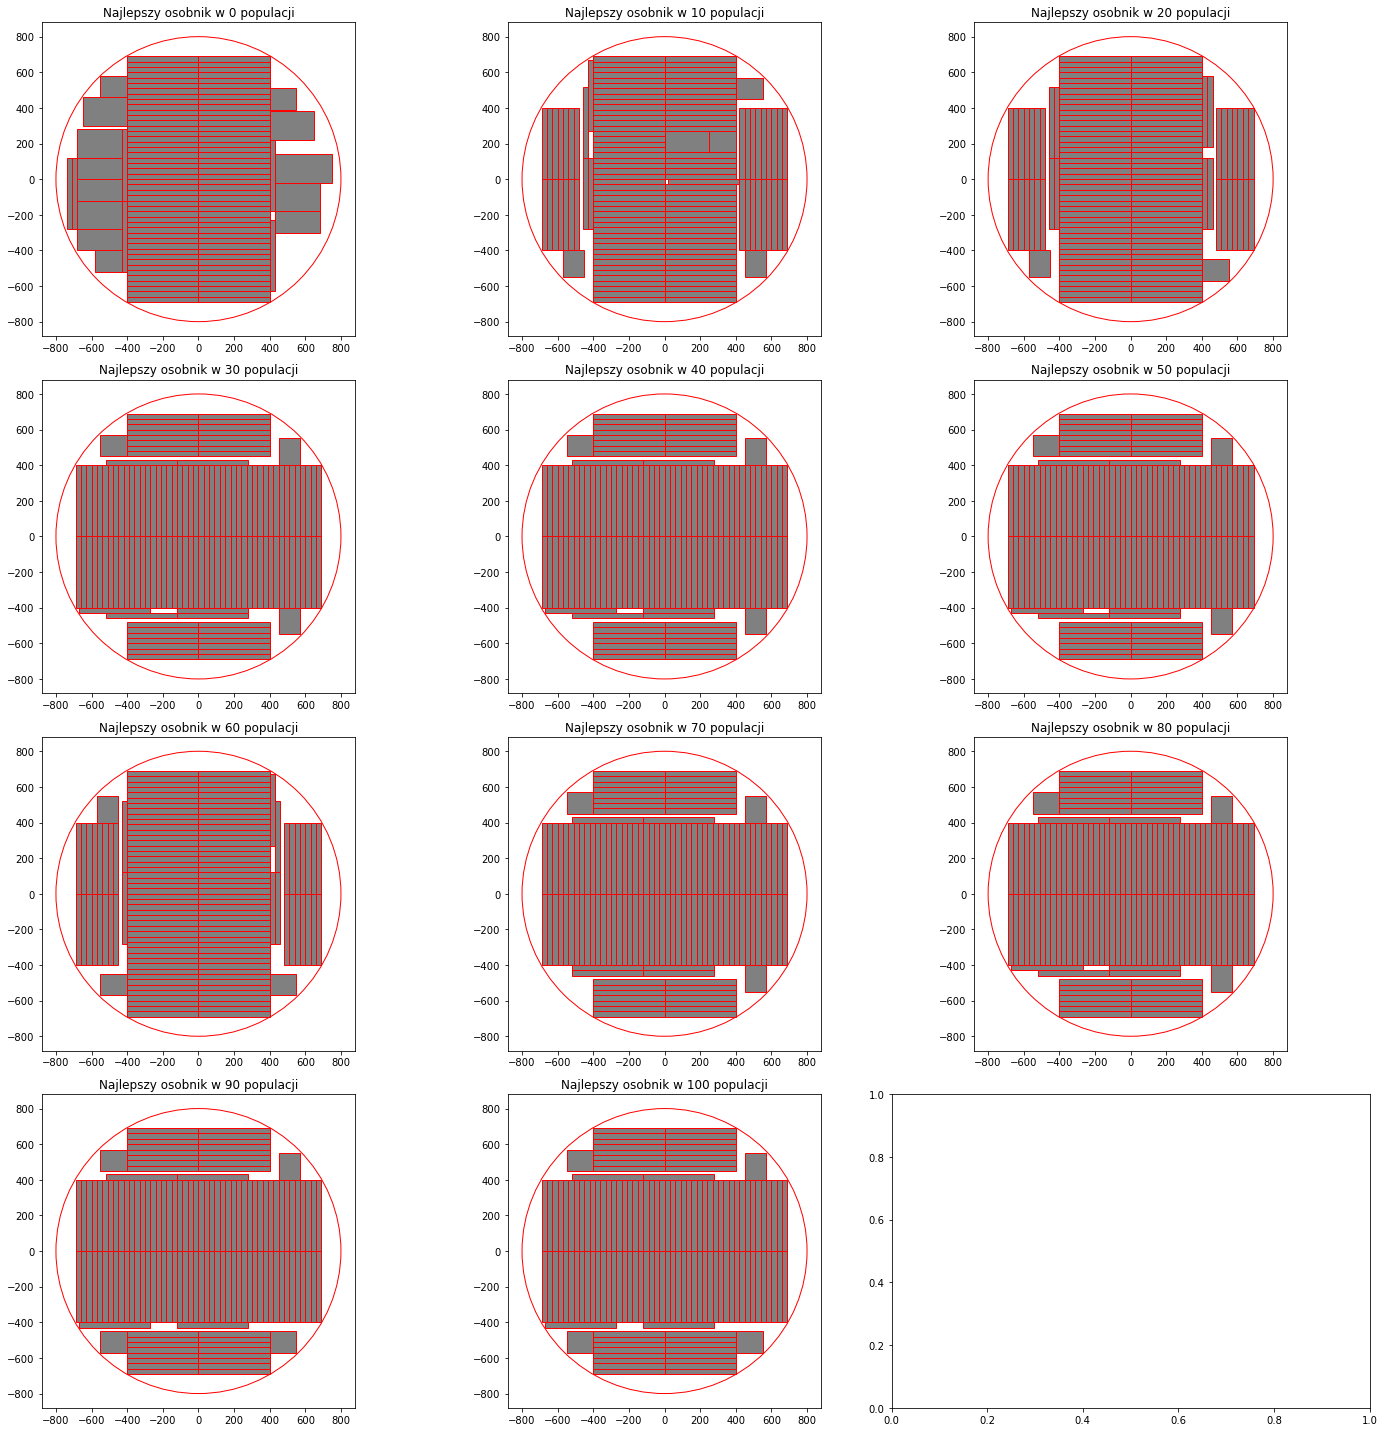

In [11]:
bests = best_individuals[::10]
names = [str(x) for x in range(0,101,10)]
plot_circles(radius,4,3,names,bests)

## `radius = 850`, pozostałe parametry domyślne, 30 osobników, 100 generacji

In [12]:
radius = 850
rectangles_table = read_data(radius)
ga = GeneticAlgorithm(radius, 30)

In [13]:
results, best_individuals = ga.train_population(100)

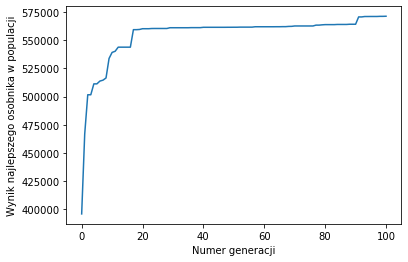

In [14]:
plot_results(results)

In [15]:
print('wartość startowa:', results[0])
print('wartość końcowa:', results[-1])

wartość startowa: 396000
wartość końcowa: 571270


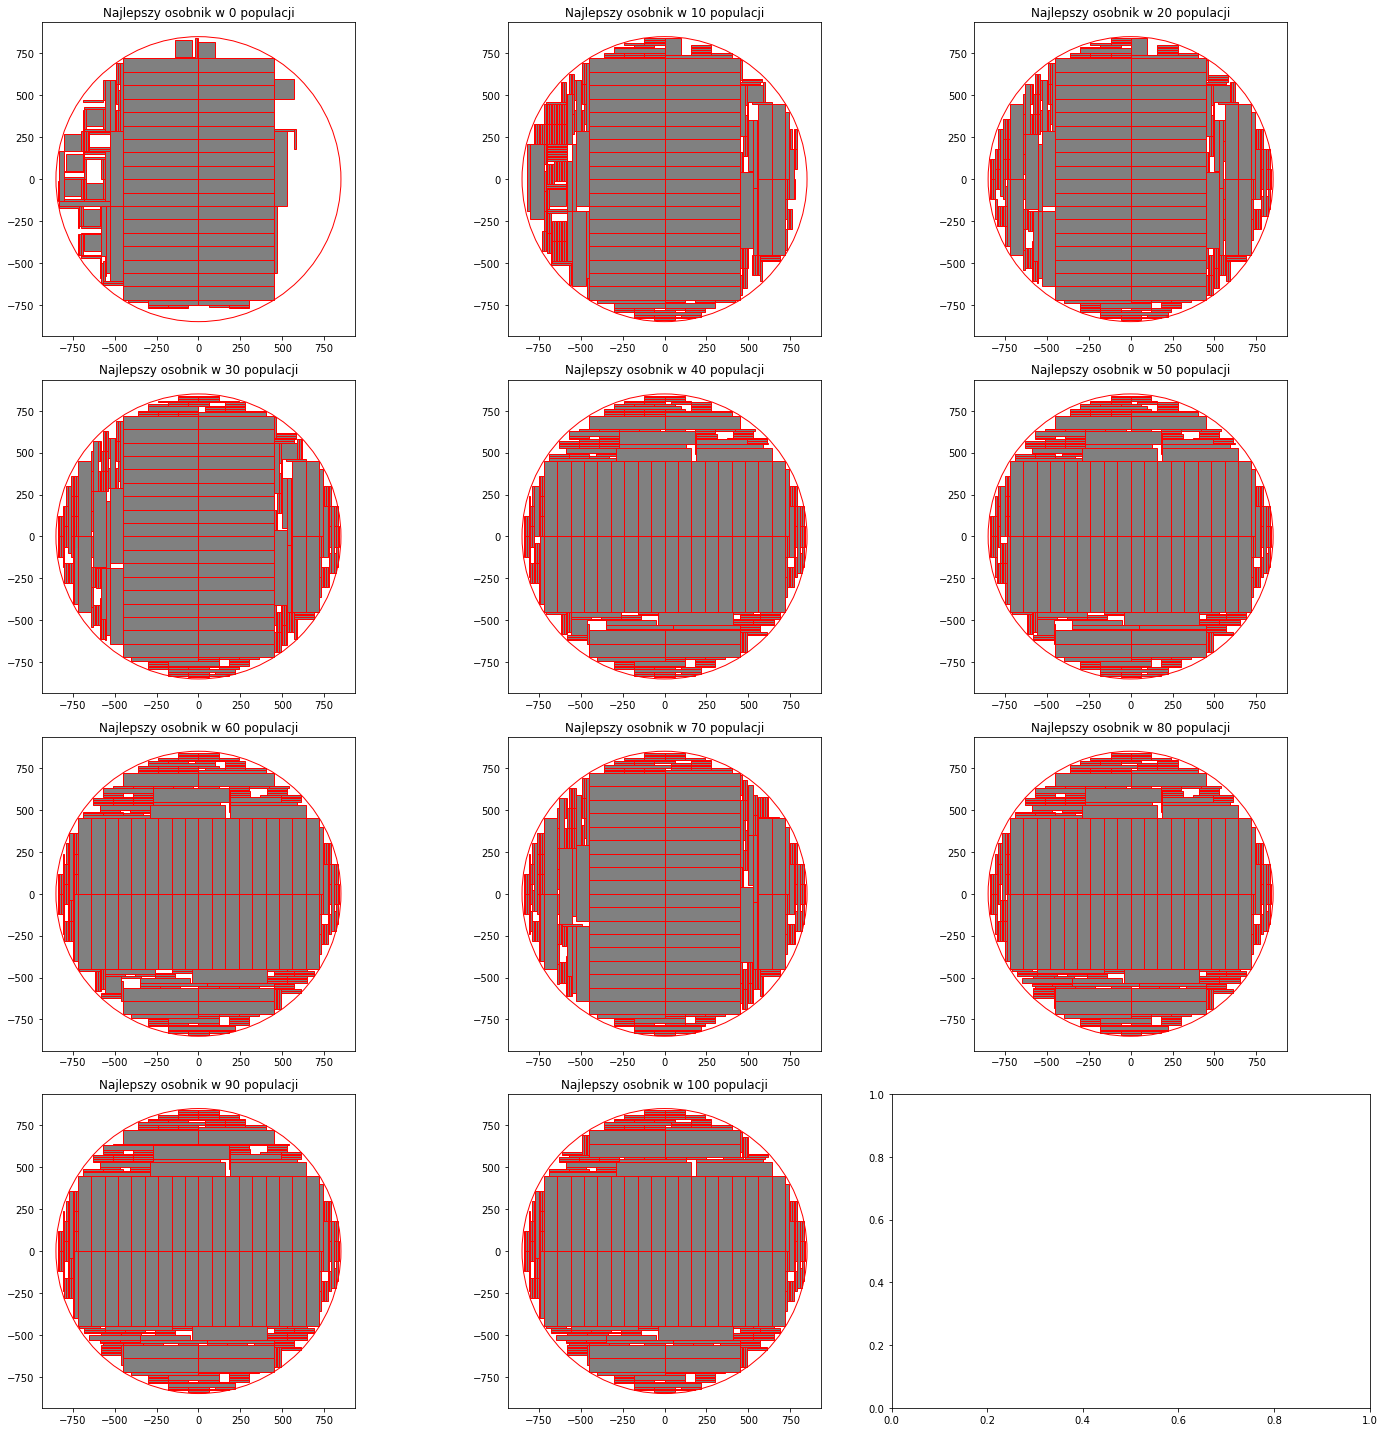

In [16]:
bests = best_individuals[::10]
names = [str(x) for x in range(0,101,10)]
plot_circles(radius,4,3,names,bests)

## `radius = 1000`, pozostałe parametry domyślne, 30 osobników, 100 generacji

In [17]:
radius = 1000
rectangles_table = read_data(radius)
ga = GeneticAlgorithm(radius, 30)

In [18]:
results, best_individuals = ga.train_population(100)

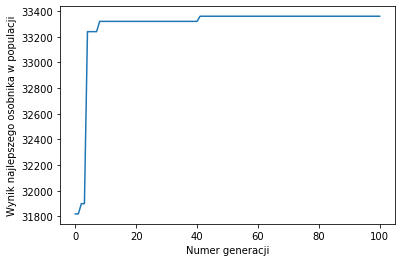

In [19]:
plot_results(results)

In [20]:
print('wartość startowa:', results[0])
print('wartość końcowa:', results[-1])

wartość startowa: 31820
wartość końcowa: 33360


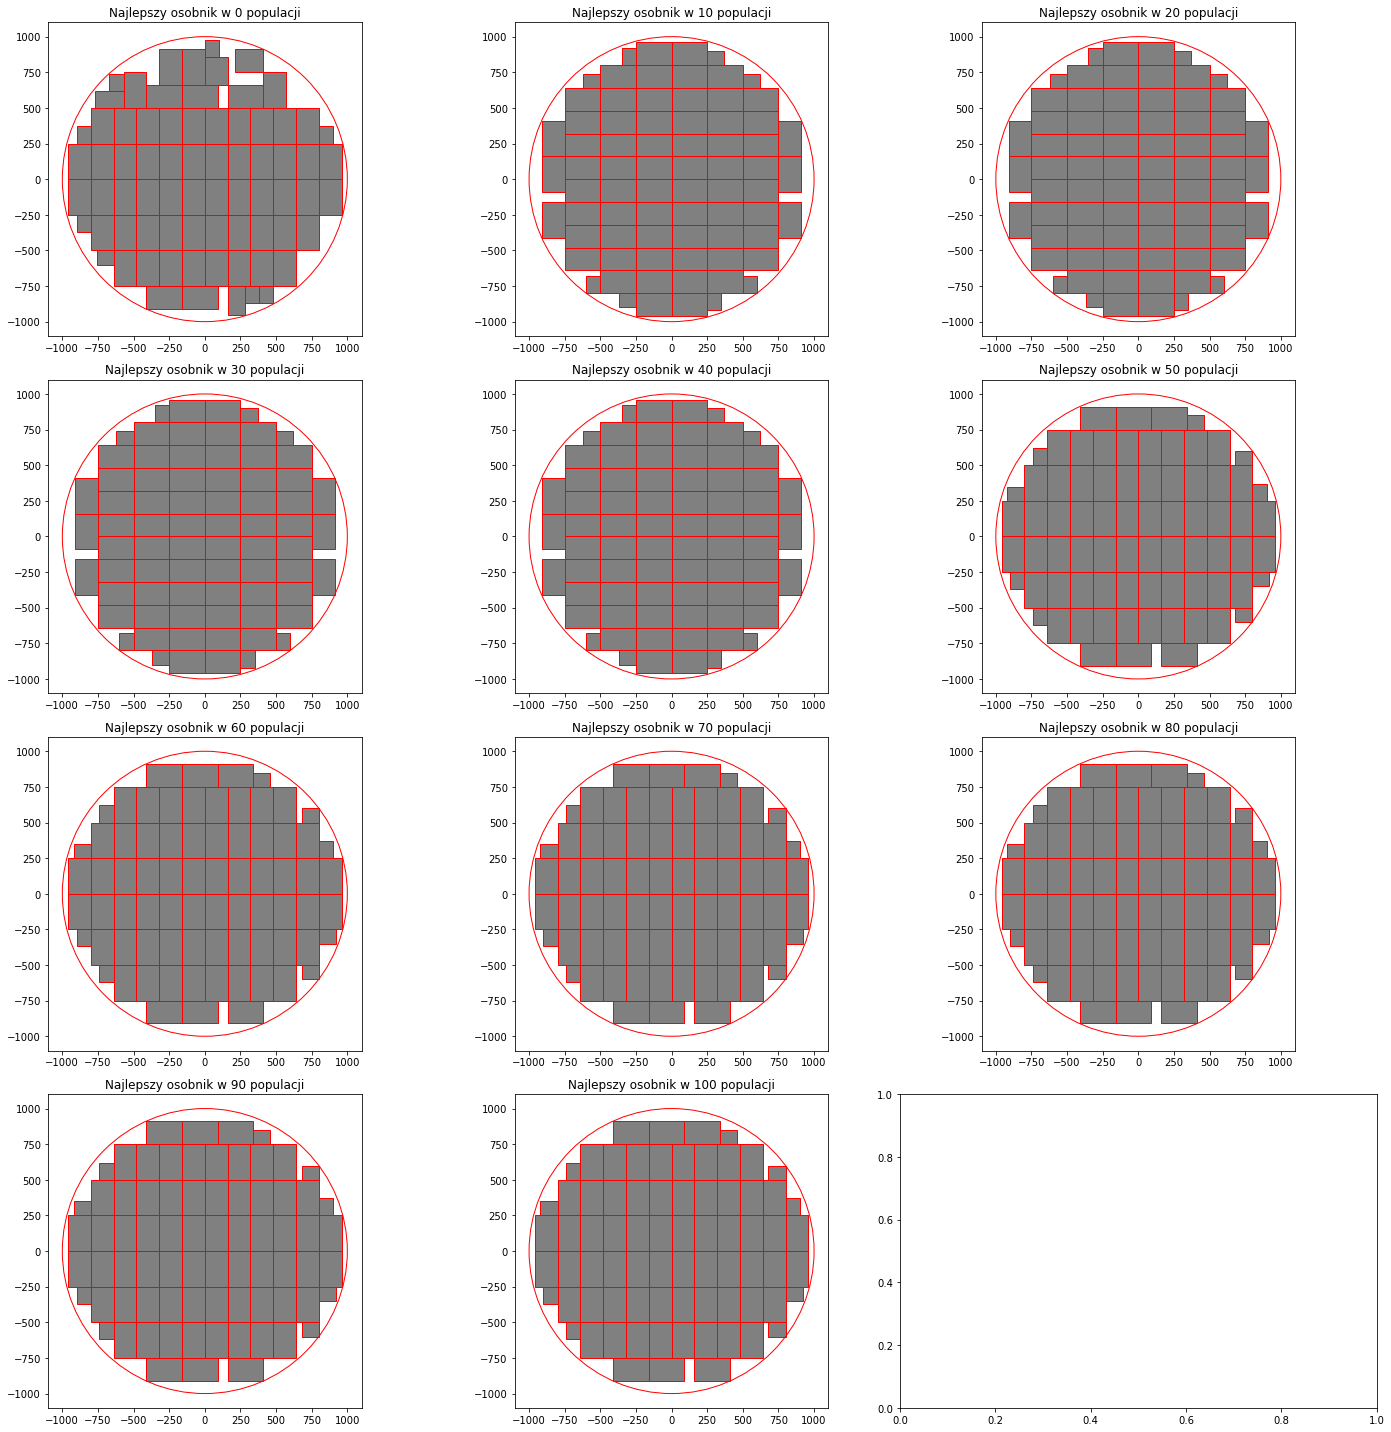

In [21]:
bests = best_individuals[::10]
names = [str(x) for x in range(0,101,10)]
plot_circles(radius,4,3,names,bests)

## `radius = 1100`, pozostałe parametry domyślne, 30 osobników, 100 generacji

In [22]:
radius = 1100
rectangles_table = read_data(radius)
ga = GeneticAlgorithm(radius, 30)

In [23]:
results, best_individuals = ga.train_population(100)

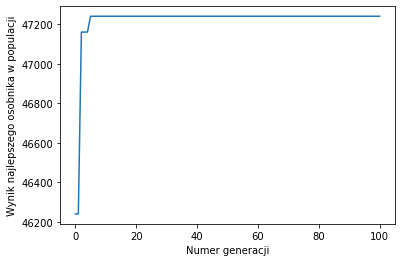

In [24]:
plot_results(results)

In [25]:
print('wartość startowa:', results[0])
print('wartość końcowa:', results[-1])

wartość startowa: 46240
wartość końcowa: 47240


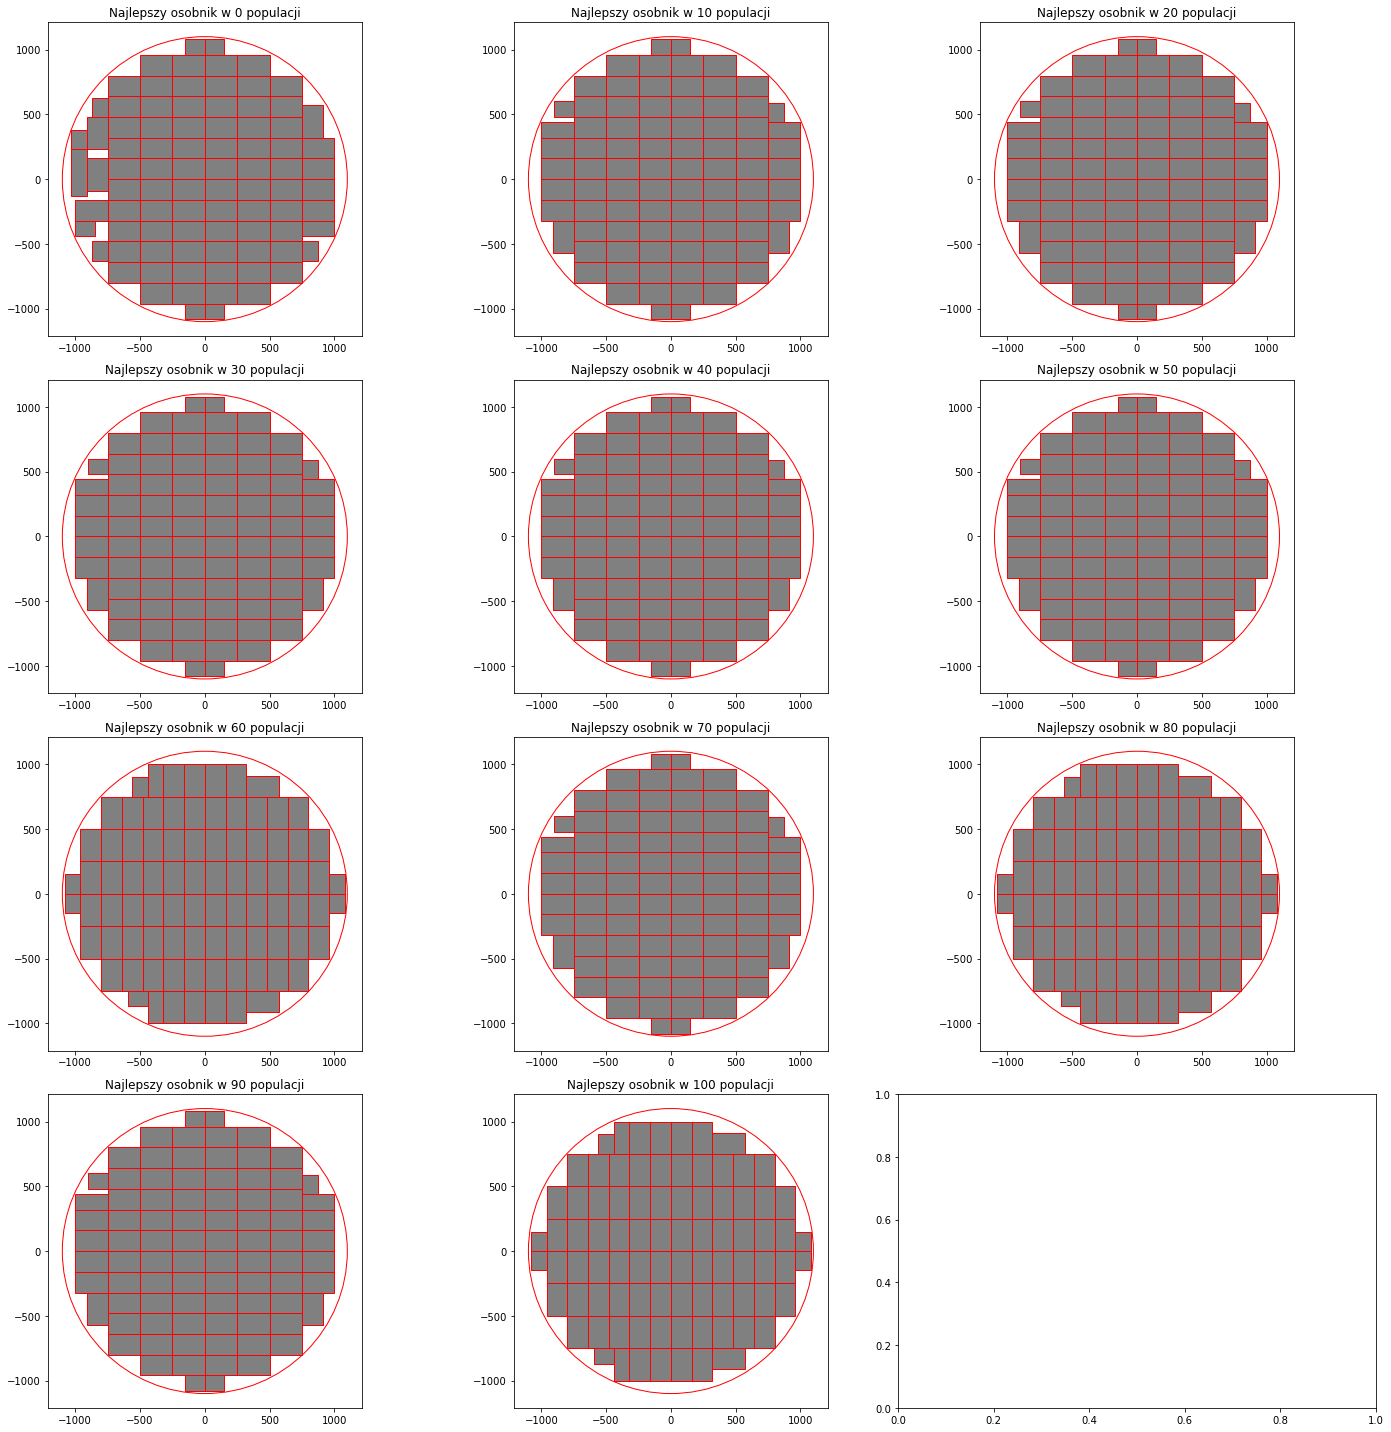

In [26]:
bests = best_individuals[::10]
names = [str(x) for x in range(0,101,10)]
plot_circles(radius,4,3,names,bests)

## `radius = 1200`, pozostałe parametry domyślne, 30 osobników, 30 generacji

In [30]:
radius = 1200
rectangles_table = read_data(radius)
ga = GeneticAlgorithm(radius, 30)

In [31]:
results, best_individuals = ga.train_population(30)

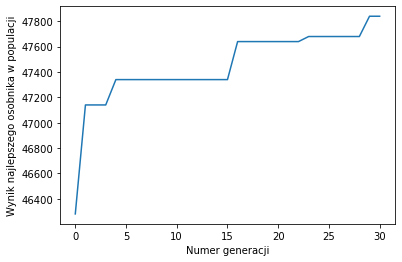

In [32]:
plot_results(results)

In [33]:
print('wartość startowa:', results[0])
print('wartość końcowa:', results[-1])

wartość startowa: 46280
wartość końcowa: 47840


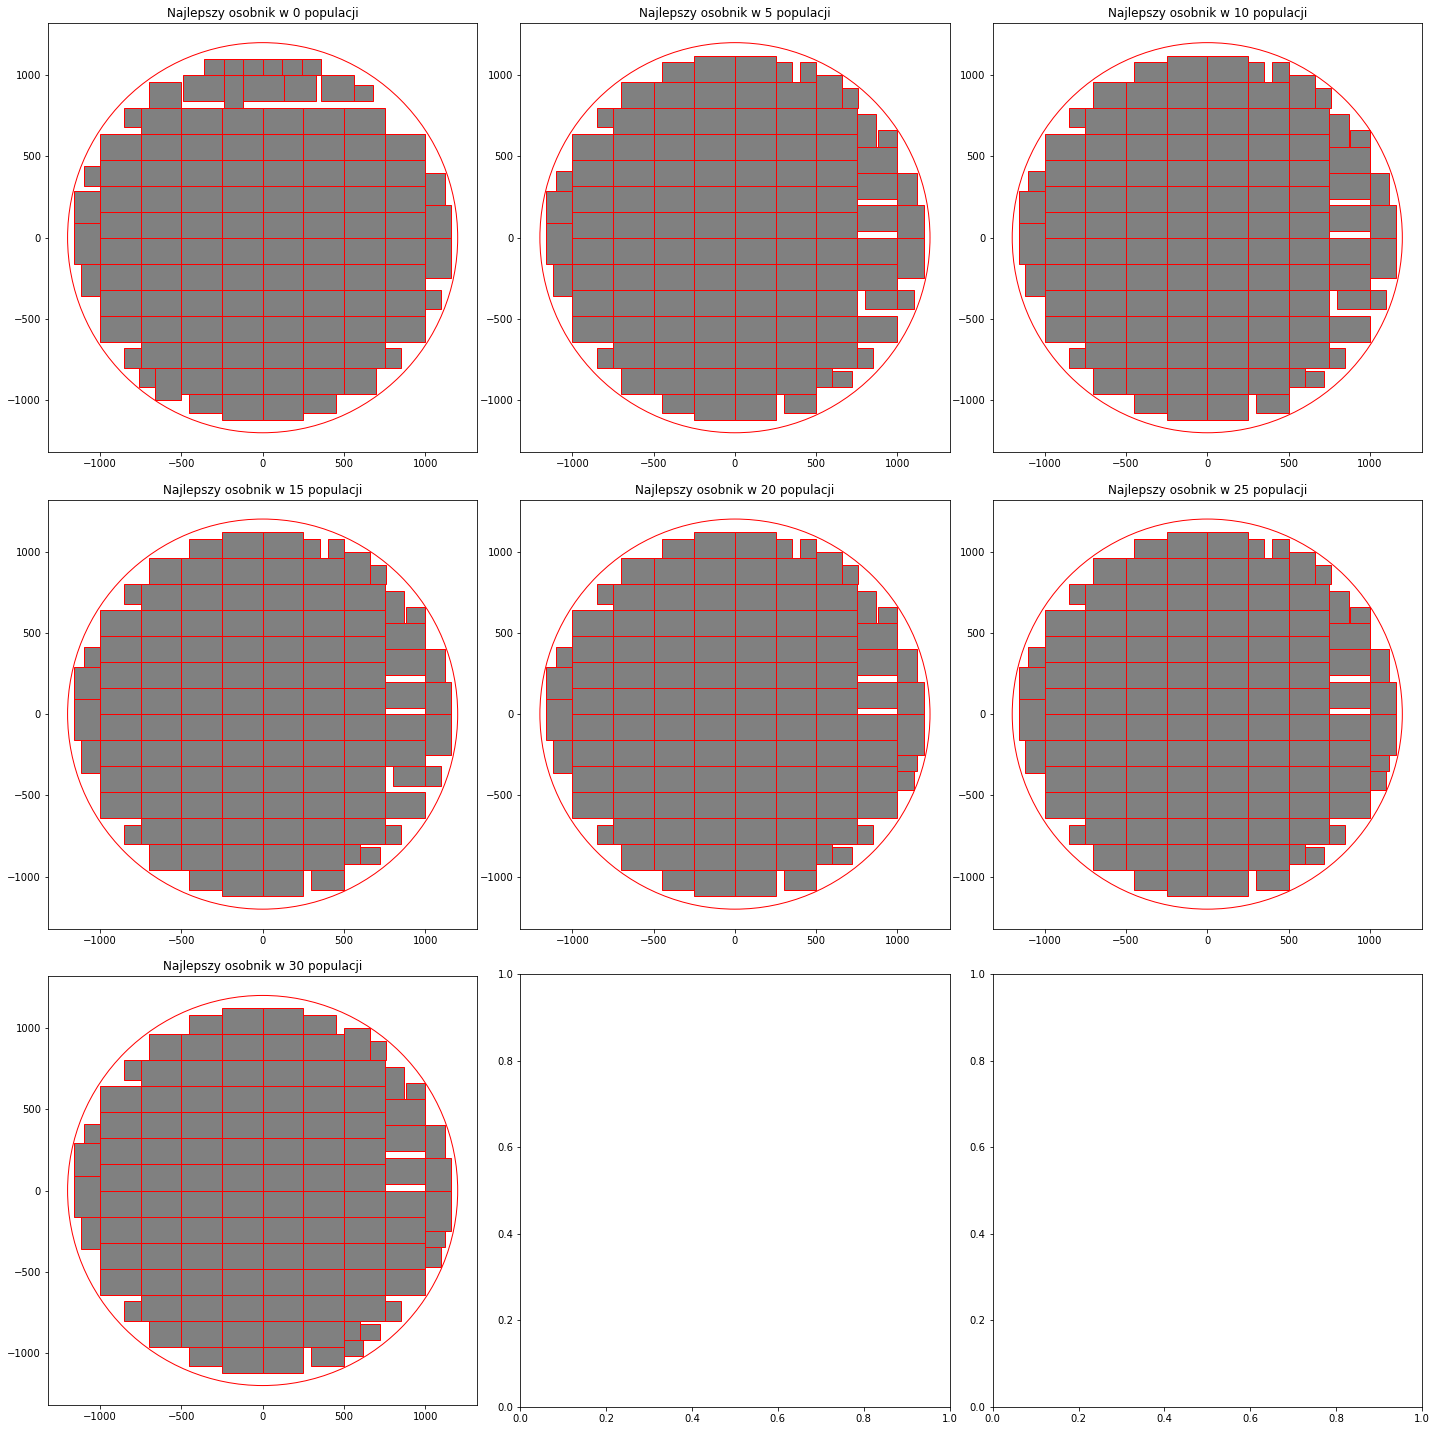

In [34]:
bests = best_individuals[::5]
names = [str(x) for x in range(0,31,5)]
plot_circles(radius,3,3,names,bests)

## Wnioski i pomysły

Zaprezentowany algorytm całkiem dobrze się uczy i polepsza osiągane wyniki.

Bardzo dobre wyniki są już osiągane przez zainicjalizowane 'ręcznie' rozkłady prostokątów (prostokąty jednego typu) i widać, że stają się one podstawą do dalszego krzyżowania osobników. Mimo to wynik funkcji celu stale polepsza się.

Już po kilku generacjach wyniki są zadowalające, testy dla 100 generacji przeprowadziłam, żeby przekonać się, czy wynik będzie nadal rósł. Jest tak dla zbiorów prostokatów o zróżnicowanych wymairach (`r=800` i `r=850`). W innych zbiorach prostokąty mają zbliżone wymiary i przyjęta inicjalizacja trochę blokuje dalszą zmienność osobników. W przyszłości pomyślałabym o bardziej losowej inicjalizacji algorytmu.

Kolejne polepszenia mogłyby przynieść inne rodzaje mutacji, między innymi przesuwanie prostokątów. 

Poza tym zaimplementowane przeze mnie wstawianie prostokątow (tylko w wierzchołkach już istniejących) nie zapełnia całego dostępnego miejsca.

Warto by jeszcze przetestować dla jakich wartości parametrów (`elit`, `rotation_ratio`, `deletion_ratio`) wyniki będą najlepsze, ale niestety tego już nie zdążyłam.